In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk import word_tokenize

In [2]:
subreddit_1 = 'wallstreetbets'
subreddit_2 = 'investing'

In [3]:
df1 = pd.read_csv(f'../data/{subreddit_1}.csv')
df2 = pd.read_csv(f'../data/{subreddit_2}.csv')

In [4]:
df = df1.append(df2).reset_index()

In [5]:
df['sub_target'] = np.where(df['subreddit'] == df['subreddit'][0], 1, 0)
print(f"Target (1) is {df['subreddit'][0]}.")

Target (1) is wallstreetbets.


In [6]:
df.drop_duplicates(subset=['title', 'selftext', 'author'], inplace=True)

In [7]:
df.fillna(' ', inplace=True)

In [8]:
df['combined'] = (df['title'] + ' ' + df['selftext']).str.lower()

In [9]:
df['char_count'] = df['combined'].str.len()
df['word_count'] = df['combined'].str.count(' ') + 1

In [10]:
df.to_csv(f'../data/joined_{subreddit_1}_{subreddit_2}.csv')

In [11]:
df['sub_target'].value_counts(normalize=True)

1    0.504633
0    0.495367
Name: sub_target, dtype: float64

In [12]:
df['char_count'].describe()

count    19858.000000
mean       841.700222
std       1408.337772
min          6.000000
25%        341.000000
50%        500.000000
75%        842.750000
max      39979.000000
Name: char_count, dtype: float64

In [13]:
df['word_count'].describe()

count    19858.000000
mean       137.330899
std        210.765588
min          2.000000
25%         58.000000
50%         86.000000
75%        141.000000
max       5955.000000
Name: word_count, dtype: float64

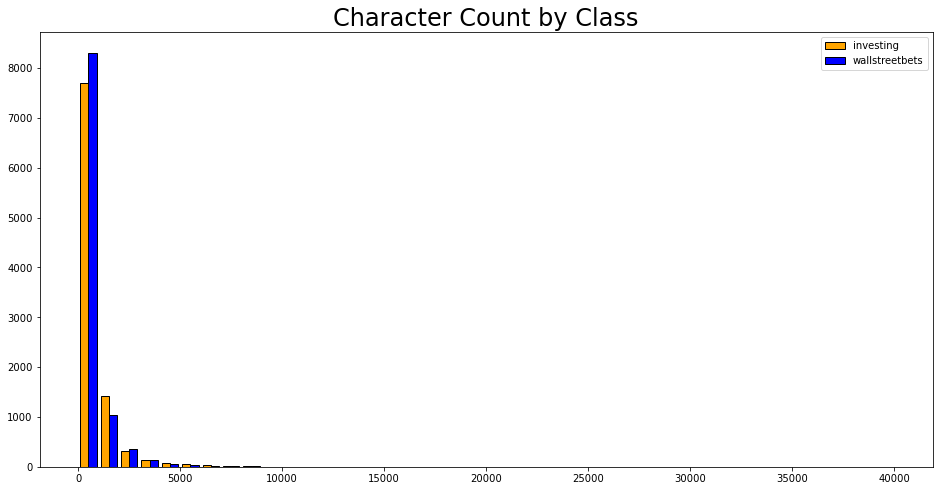

In [14]:
plt.figure(figsize=(16,8))
plt.hist([df[df['sub_target']==0]['char_count'], 
          df[df['sub_target']==1]['char_count']],
         bins=40, color=['orange', 'blue'], ec='k')
plt.title('Character Count by Class', fontsize=24)
plt.legend([f'{subreddit_2}', f'{subreddit_1}']);

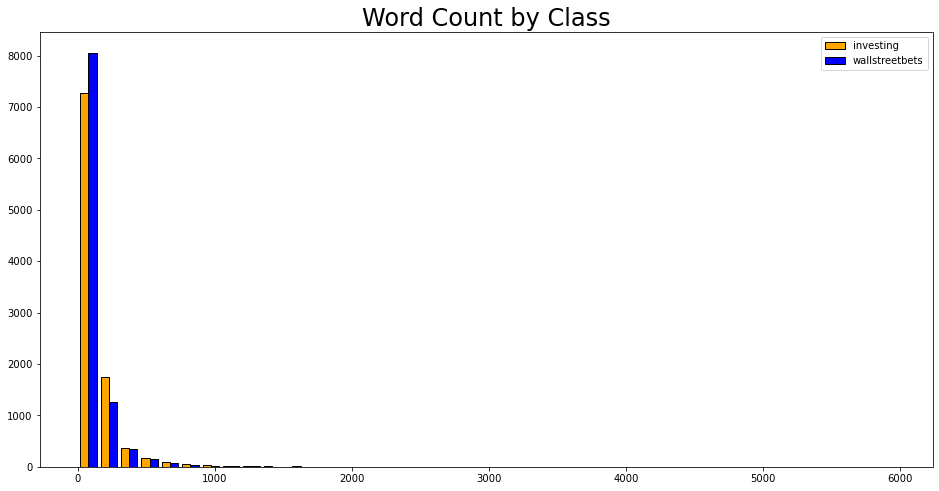

In [15]:
plt.figure(figsize=(16,8))
plt.hist([df[df['sub_target']==0]['word_count'], 
          df[df['sub_target']==1]['word_count']],
         bins=40, color=['orange', 'blue'], ec='k')
plt.title('Word Count by Class', fontsize=24)
plt.legend([f'{subreddit_2}', f'{subreddit_1}']);

In [16]:
X = df['combined']
y = df['sub_target']

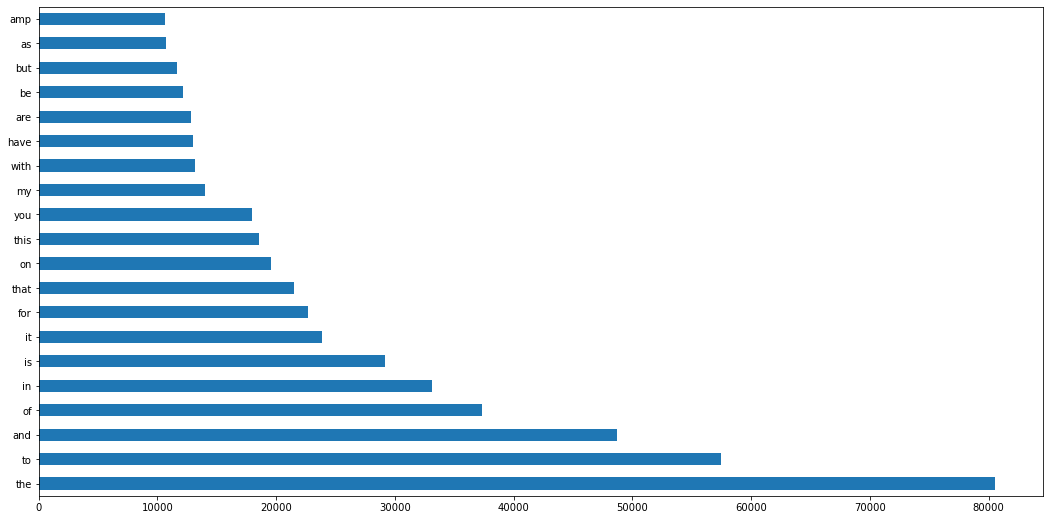

In [17]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, random_state=42)

cvec = CountVectorizer()

X_train = cvec.fit_transform(X_train)
X_validation = cvec.transform(X_validation)

X_train_df = pd.DataFrame(X_train.todense(), columns=cvec.get_feature_names())

plt.figure(figsize=(18, 9))
X_train_df.sum().sort_values(ascending=False).head(20).plot(kind='barh');

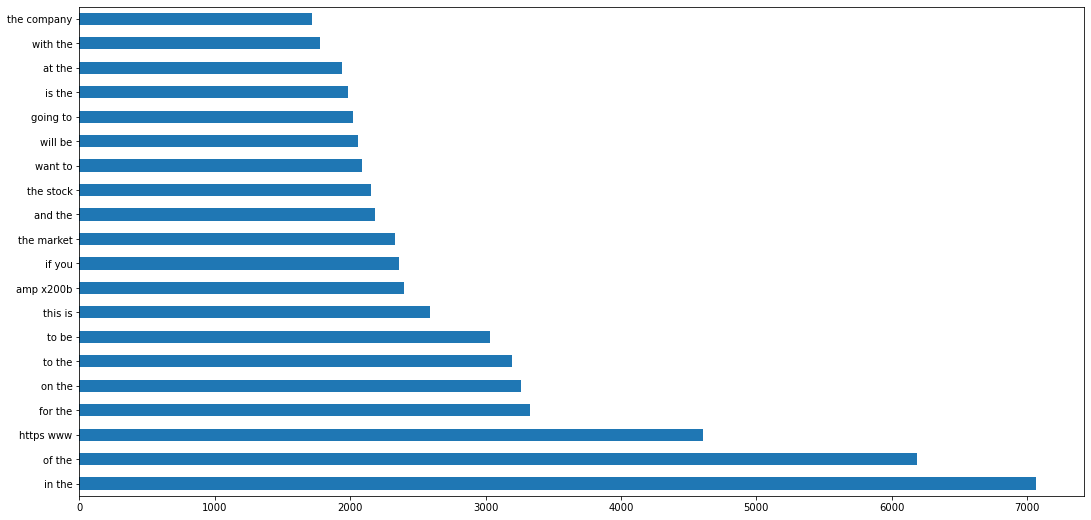

In [18]:
X_train_2, X_validation_2, y_train_2, y_validation_2 = train_test_split(X, y, random_state=42)

cvec = CountVectorizer(ngram_range=(2,2))

X_train_2 = cvec.fit_transform(X_train_2)
X_validation_2 = cvec.transform(X_validation_2)

X_train_df_2 = pd.DataFrame(X_train_2.todense(), columns=cvec.get_feature_names())

plt.figure(figsize=(18, 9))
X_train_df_2.sum().sort_values(ascending=False).head(20).plot(kind='barh');